In [98]:
#!pip install mne
import mne
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import os
from scipy import signal
from matplotlib.pyplot import figure

Считаем данные в формате edf

In [320]:
file = "ЭКГ_Паша.edf"
data = mne.io.read_raw_edf(file)
raw_data = data.get_data()
# you can get the metadata included in the file and a list of all channels:
info = data.info
channels = data.ch_names

Extracting EDF parameters from c:\Users\Pasha\Desktop\Мага БМТ1\4 term\КП Бойко\vector_ECG\ЭКГ_Паша.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [53]:
channels[0]

'ECG I-Ref'

In [18]:
info

<Info | 7 non-empty values
 bads: []
 ch_names: ECG I-Ref, ECG II-Ref, ECG III-Ref, ECG AVR-Ref, ECG AVL-Ref, ...
 chs: 12 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: 2023-05-24 17:52:28 UTC
 nchan: 12
 projs: []
 sfreq: 250.0 Hz
>

In [4]:
fd = 250 # Частота дискретизации
raw_data.shape

(12, 7500)

In [321]:
df = pd.DataFrame(data=raw_data.T,    # values
...              index=range(raw_data.shape[1]),    # 1st column as index
...              columns=channels)  # 1st row as the column names
df

,ECG I-Ref,ECG II-Ref,ECG III-Ref,ECG AVR-Ref,ECG AVL-Ref,ECG AVF-Ref,ECG V1-Ref,ECG V2-Ref,ECG V3-Ref,ECG V4-Ref,ECG V5-Ref,ECG V6-Ref
0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,-0.00002,0.00002,0.00004,0.00000,-0.00003,0.00003,-0.00002,0.00001,0.00001,0.00000,0.00001,0.00002
2,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-0.00003,0.00002,0.00001,0.00001,0.00002,0.00002
3,-0.00001,0.00004,0.00005,-0.00001,-0.00004,0.00005,-0.00001,0.00005,0.00004,0.00003,0.00004,0.00004
4,0.00005,0.00006,0.00001,-0.00005,0.00001,0.00004,0.00002,0.00006,0.00005,0.00005,0.00006,0.00005
...,...,...,...,...,...,...,...,...,...,...,...,...
7495,0.00000,0.00034,0.00034,-0.00017,-0.00017,0.00034,0.00010,-0.00003,0.00031,-0.00032,-0.00014,-0.00016
7496,0.00005,0.00038,0.00033,-0.00021,-0.00015,0.00036,0.00009,-0.00006,0.00030,-0.00034,-0.00016,-0.00018
7497,0.00006,0.00040,0.00034,-0.00023,-0.00014,0.00037,0.00014,-0.00004,0.00032,-0.00033,-0.00014,-0.00017
7498,-0.00001,0.00036,0.00037,-0.00017,-0.00020,0.00037,0.00012,-0.00004,0.00030,-0.00034,-0.00016,-0.00019


In [322]:
Ts = 1/fd
t = []
for i in range(raw_data.shape[1]):
    t.append(i*Ts)
max(t)

29.996000000000002

### Линейная интерполяция сигналов ЭКГ

(Catboost был обучен для частоты дискретизации 500 Гц, а полученные сигналы ЭКГ записаны с частотой дискретизации 250 Гц, поэтому необходимо сделать передискретизацию сигналов в 2 раза для получения частоты дискретизации 500 Гц)

In [270]:
#интерполяция на примере 1 сигнала

signal_temp=df.iloc[:,0]
signal_temp

0       0.00000
1       0.00001
2       0.00002
3       0.00000
4       0.00000
         ...   
7495   -0.00022
7496   -0.00023
7497   -0.00023
7498   -0.00022
7499   -0.00023
Name: ECG I-Ref, Length: 7500, dtype: float64

In [271]:
from scipy import interpolate

interpol_signal = interpolate.interp1d(t, signal_temp, kind = 'linear')
time1 = [i*Ts/2 for i in range((len(signal_temp)-1)*2)]
new_signal = interpol_signal(time1)
#print(type(new_signal))

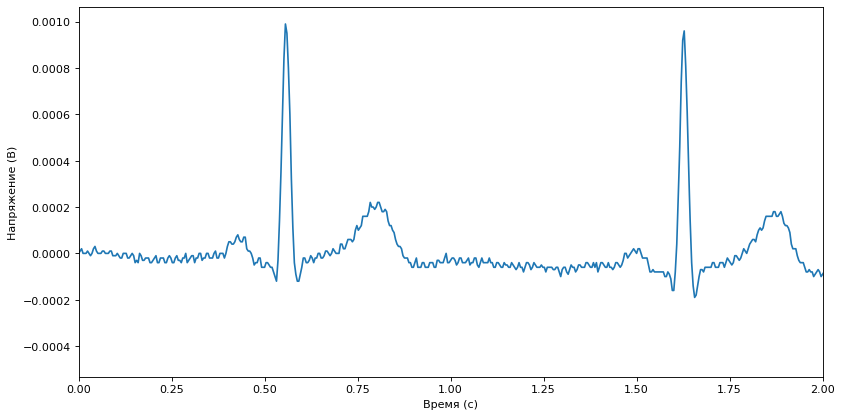

In [272]:
#проверка полученного сигнала

plt.figure(figsize=(12, 6), dpi=80)
plt.plot(time1, new_signal)
plt.xlabel('Время (с)')
plt.ylabel('Напряжение (В)')
plt.xlim([0, 2])
plt.show()

In [25]:
#проверка размерности полученного сигнала

new_signal.shape

(14998,)

In [182]:
#функция линейной интерполяции сигнала

def interpolate_df(df):
    
    interpol_df=pd.DataFrame()
    
    #задание нового времени
    time1 = [i*Ts/2 for i in range((df.shape[0]-1)*2)]
    df_time=pd.DataFrame(data=np.array(time1), columns=['time'])
    interpol_df=pd.concat([interpol_df, df_time], axis=1)
    
    #интерполяция сигнала ЭКГ с 12 отведений
    for i in range(df.shape[1]):
        signal_temp=df.iloc[:,i]
        interpol_signal = interpolate.interp1d(t, signal_temp, kind = 'linear')
        new_signal = interpol_signal(time1)
        temp_df=pd.DataFrame(data=np.array(new_signal), columns=[channels[i]])
        interpol_df=pd.concat([interpol_df, temp_df], axis=1)
    
    #время как индекс
    interpol_df=interpol_df.set_index('time')
    
    return interpol_df


In [323]:
df_new=interpolate_df(df)

Нахождение пиков за счёт Catboost

In [11]:
from catboost import CatBoostClassifier
model = CatBoostClassifier()      # parameters not required.
model.load_model('boosting_model_ECG.cbm');

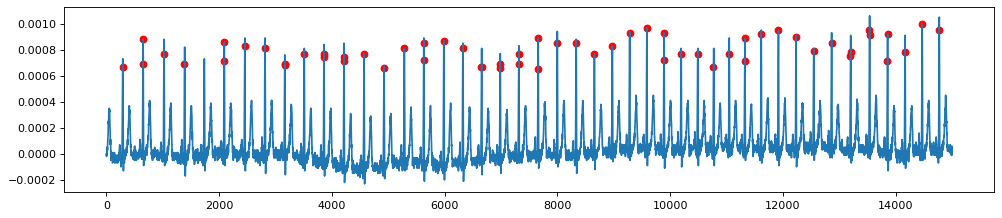

In [324]:
sig = np.array(df_new.iloc[:,0])
window = 200
dataset_check = []
middles = []
for i in range(0, len(sig)-window, 6):
    piece = sig[i:i+window] / np.max(np.abs(sig[i:i+window]))
    piece = piece - np.mean(piece)
    middle = (i + i + window) / 2
    middles.append(middle)
    dataset_check.append(piece)
df_check = pd.DataFrame(dataset_check)
test_preds = model.predict(df_check, prediction_type="Class")
peaks = np.where(test_preds>0)[0]

# Сделаем временный сигнал, который всегда имеет min значение = 0
temp_sig = sig
if min(sig) < 0:
    temp_sig = sig + abs(min(sig))
if min(sig) > 0:
    temp_sig = sig - abs(min(sig))

h = max(temp_sig)/1.5  # Выберем только те пики, которые >
true_peaks = []

for i in peaks:
    m = int(middles[i])
    if temp_sig[m]>h:
        true_peaks.append(i)


middles = np.asarray(middles)
figure(figsize=(15, 3), dpi=80)
plt.plot(sig)
plt.scatter(middles[true_peaks], [list(sig)[x] for x in list((middles[true_peaks]).astype(np.int64))], color='red')
#plt.xlim([0, 5000]);

Сделаем так, чтобы один кардиоцикл имел ровно 1 задетектированный пик. 
Условие будет такое: если между соседними пиками расстояние меньше чем 0.2 мс, тогда оставить надо как значение пика - среднее значение между точками

In [325]:
coordinates = middles[true_peaks].astype(np.int64)
coordinates = np.concatenate((coordinates, max(coordinates)+10000),axis=None)
final_coord = []
val_last = 0
data_points = []
for val in coordinates:
    if val - val_last > (0.2/Ts):
        if len(data_points)!=0:
            final_coord.append(int(np.array(data_points).mean()))
            data_points = []
    data_points.append(val)
    val_last = val

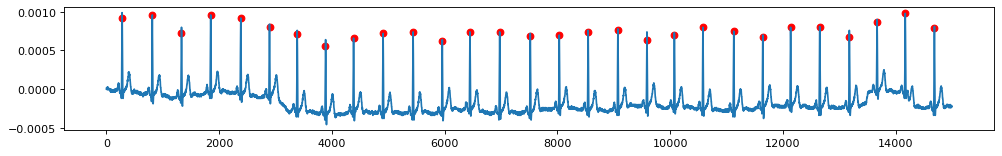

In [276]:
figure(figsize=(15, 2), dpi=80)
plt.plot(sig)
plt.scatter(final_coord, sig[final_coord], color='red')
#plt.xlim([0, 5000]);

Так как все сигналы записаны отновременно со всех отведений, поэтому эти же найденные координаты на 1 отведении можно перенести с легкостью на все остальные

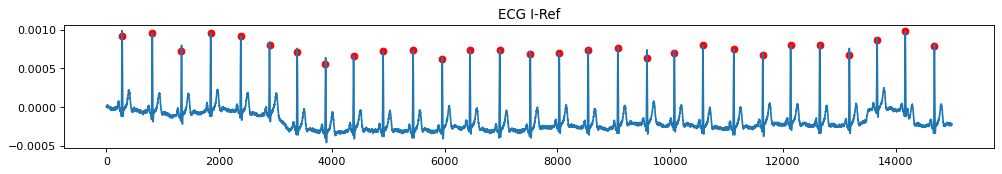

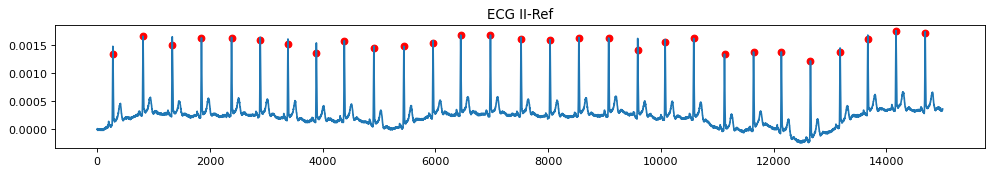

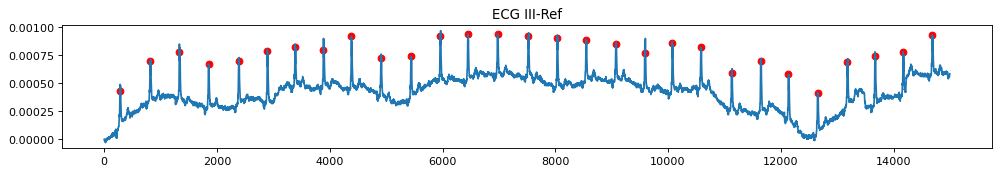

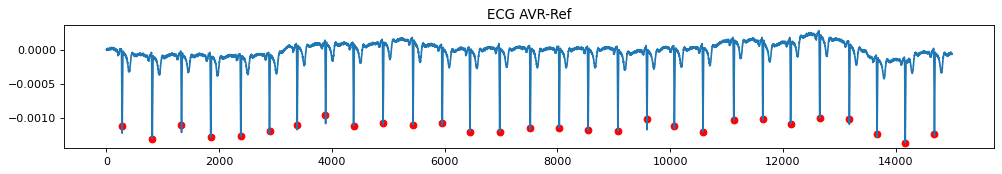

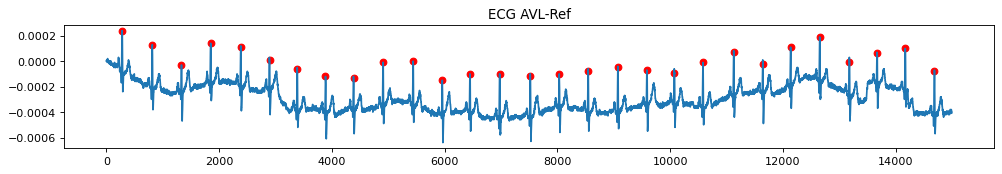

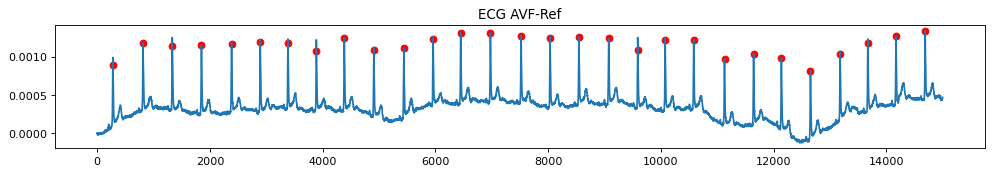

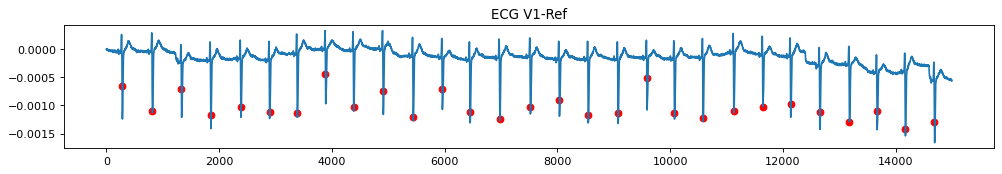

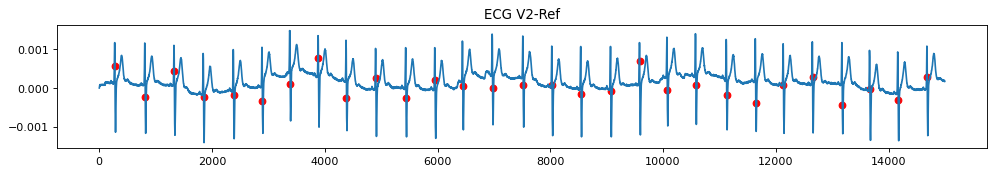

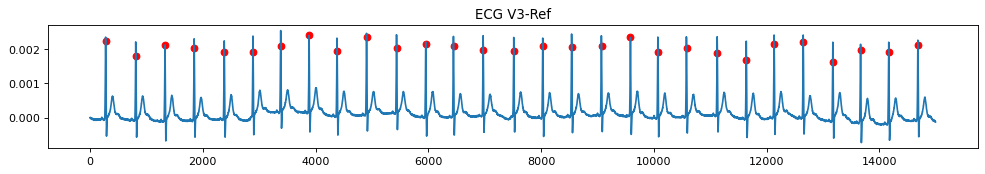

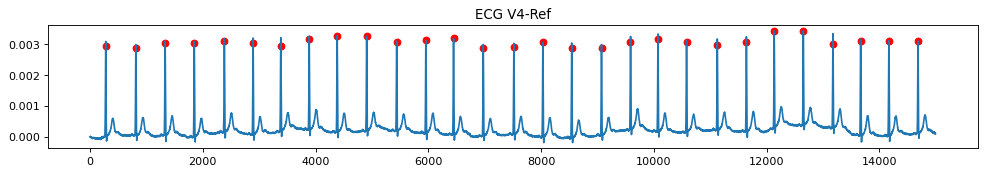

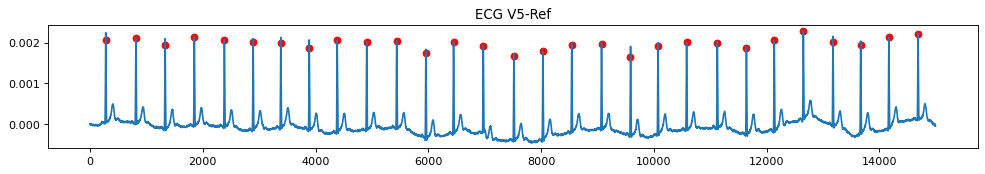

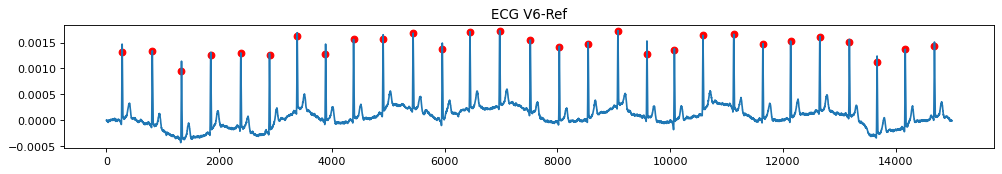

In [277]:
for graph in channels:
    sig = np.array(df_new[graph])
    figure(figsize=(15, 2), dpi=80)
    plt.plot(sig)
    plt.scatter(final_coord, sig[final_coord], color='red')
    plt.title(graph)
    #plt.xlim([0, 5000]);

Можно еще попробовать реализовать фильтрацию ФВЧ чтобы убрать артефакты дыхания

Фильтр 3 порядка с f среза = 0.5 Гц

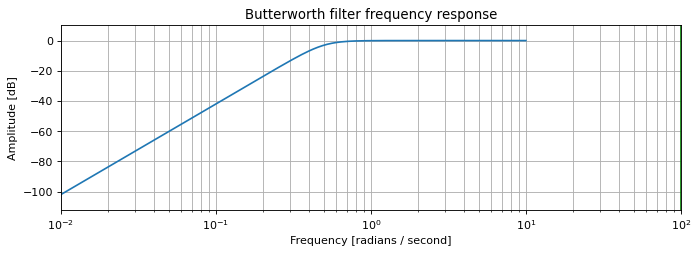

In [99]:
b, a = signal.butter(3, 0.5, 'hp', analog=True)
w, h = signal.freqs(b, a)
figure(figsize=(10, 3), dpi=80)
plt.semilogx(w, 20 * np.log10(abs(h)))
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [radians / second]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(100, color='green') # cutoff frequency
plt.show()

Возьмем как пример сигнал со 2 отведения:

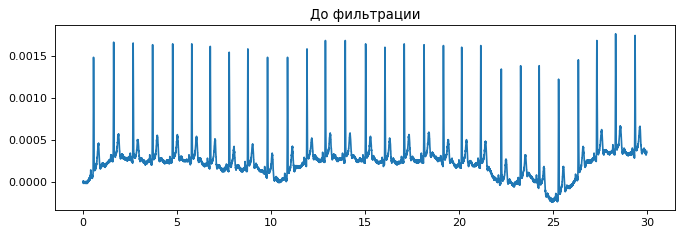

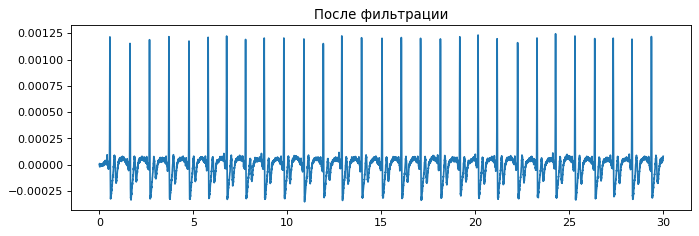

In [278]:
sig = np.array(df_new['ECG II-Ref'])
sos = signal.butter(3, 0.5, 'hp', fs=fd, output='sos')
filtered = signal.sosfilt(sos, sig)
figure(figsize=(10, 3), dpi=80)
plt.plot(time1, sig)
plt.title('До фильтрации')
plt.show()
figure(figsize=(10, 3), dpi=80)
plt.plot(time1, filtered)
plt.title('После фильтрации')
plt.show()

Так что можно перед нахождением вЭКГ заранее фильтром ФВЧ отфильтровать сигналы всех отведений. Данное действие реализуем опционально

### Поиск вЭКГ

[Статья, в которой есть формула для вычисления проекций диполя](article.pdf)

Нам требуется выделить 1 период кардиоцикла и для него расчитать. Я собираюсь взять 3 и 4 периоды

In [326]:
i = int(input('Введите значение с какого периода начать отсчет'))
print(f"Запрошен {i} период")
start = final_coord[i-1]
end = final_coord[i]

Запрошен 3 период


In [327]:
df_term = df_new.iloc[start:end,:]
df_term

,ECG I-Ref,ECG II-Ref,ECG III-Ref,ECG AVR-Ref,ECG AVL-Ref,ECG AVF-Ref,ECG V1-Ref,ECG V2-Ref,ECG V3-Ref,ECG V4-Ref,ECG V5-Ref,ECG V6-Ref
time,,,,,,,,,,,,
2.036,0.00077,0.000700,-0.000070,-0.000730,0.000410,0.000320,-0.000450,-0.000190,0.000180,0.000470,0.000590,0.000520
2.038,0.00082,0.000835,0.000015,-0.000820,0.000390,0.000430,-0.000540,-0.000310,0.000210,0.000540,0.000690,0.000630
2.040,0.00087,0.000970,0.000100,-0.000910,0.000370,0.000540,-0.000630,-0.000430,0.000240,0.000610,0.000790,0.000740
2.042,0.00087,0.001025,0.000155,-0.000940,0.000345,0.000595,-0.000680,-0.000500,0.000255,0.000655,0.000850,0.000790
2.044,0.00087,0.001080,0.000210,-0.000970,0.000320,0.000650,-0.000730,-0.000570,0.000270,0.000700,0.000910,0.000840
...,...,...,...,...,...,...,...,...,...,...,...,...
2.758,0.00013,0.000155,0.000025,-0.000140,0.000045,0.000095,0.000020,0.000280,0.000180,0.000105,0.000200,-0.000010
2.760,0.00019,0.000190,0.000000,-0.000190,0.000090,0.000100,-0.000010,0.000290,0.000210,0.000150,0.000250,0.000040
2.762,0.00030,0.000275,-0.000025,-0.000285,0.000155,0.000130,-0.000080,0.000235,0.000230,0.000210,0.000330,0.000115


In [328]:
# Задублируем первый отчет чтебы сделать график непрерывным:
df_row = df_new.iloc[start:start+1,:]
df_term = pd.concat([df_term, df_row])
df_row

,ECG I-Ref,ECG II-Ref,ECG III-Ref,ECG AVR-Ref,ECG AVL-Ref,ECG AVF-Ref,ECG V1-Ref,ECG V2-Ref,ECG V3-Ref,ECG V4-Ref,ECG V5-Ref,ECG V6-Ref
time,,,,,,,,,,,,
2.036,0.00077,0.0007,-0.00007,-0.00073,0.00041,0.00032,-0.00045,-0.00019,0.00018,0.00047,0.00059,0.00052


In [329]:
DI = df_term.iloc[:,0]
DII = df_term.iloc[:,1]
V1 = df_term.iloc[:,6]
V2 = df_term.iloc[:,7]
V3 = df_term.iloc[:,8]
V4 = df_term.iloc[:,9]
V5 = df_term.iloc[:,10]
V6 = df_term.iloc[:,11]

In [330]:
df_term['x'] = -(-0.172*V1-0.074*V2+0.122*V3+0.231*V4+0.239*V5+0.194*V6+0.156*DI-0.01*DII)
df_term['y'] = (0.057*V1-0.019*V2-0.106*V3-0.022*V4+0.041*V5+0.048*V6-0.227*DI+0.887*DII)
df_term['z'] = -(-0.229*V1-0.31*V2-0.246*V3-0.063*V4+0.055*V5+0.108*V6+0.022*DI+0.102*DII)

In [331]:
df_term

,ECG I-Ref,ECG II-Ref,ECG III-Ref,ECG AVR-Ref,ECG AVL-Ref,ECG AVF-Ref,ECG V1-Ref,ECG V2-Ref,ECG V3-Ref,ECG V4-Ref,ECG V5-Ref,ECG V6-Ref,x,y,z
time,,,,,,,,,,,,,,,
2.036,0.00077,0.000700,-0.000070,-0.000730,0.000410,0.000320,-0.000450,-0.000190,0.000180,0.000470,0.000590,0.000520,-0.000577,0.000444,-0.000265
2.038,0.00082,0.000835,0.000015,-0.000820,0.000390,0.000430,-0.000540,-0.000310,0.000210,0.000540,0.000690,0.000630,-0.000673,0.000554,-0.000343
2.040,0.00087,0.000970,0.000100,-0.000910,0.000370,0.000540,-0.000630,-0.000430,0.000240,0.000610,0.000790,0.000740,-0.000769,0.000664,-0.000422
2.042,0.00087,0.001025,0.000155,-0.000940,0.000345,0.000595,-0.000680,-0.000500,0.000255,0.000655,0.000850,0.000790,-0.000818,0.000714,-0.000462
2.044,0.00087,0.001080,0.000210,-0.000970,0.000320,0.000650,-0.000730,-0.000570,0.000270,0.000700,0.000910,0.000840,-0.000868,0.000763,-0.000503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2.760,0.00019,0.000190,0.000000,-0.000190,0.000090,0.000100,-0.000010,0.000290,0.000210,0.000150,0.000250,0.000040,-0.000136,0.000106,0.000107
2.762,0.00030,0.000275,-0.000025,-0.000285,0.000155,0.000130,-0.000080,0.000235,0.000230,0.000210,0.000330,0.000115,-0.000218,0.000157,0.000059
2.764,0.00041,0.000360,-0.000050,-0.000380,0.000220,0.000160,-0.000150,0.000180,0.000250,0.000270,0.000410,0.000190,-0.000301,0.000208,0.000011


<image src="https://cf.ppt-online.org/files/slide/j/jwUOHvuLkin8pdx01KmTBc7YRIDs5JZgF9tXyN/slide-37.jpg">

[]

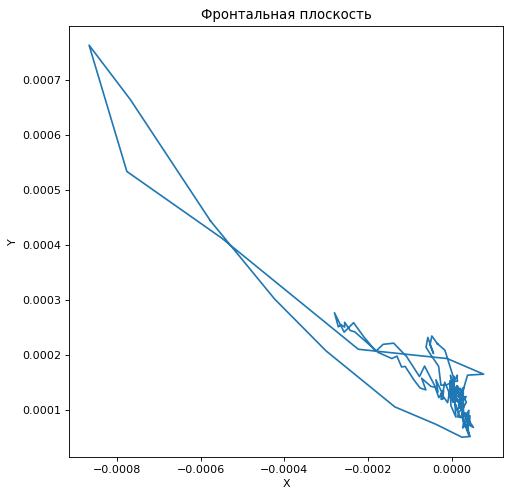

In [332]:
plt.figure(figsize=(7, 7), dpi=80)
plt.plot(df_term.x,df_term.y)
plt.title('Фронтальная плоскость')
plt.xlabel('X')
plt.ylabel('Y')
plt.plot()

[]

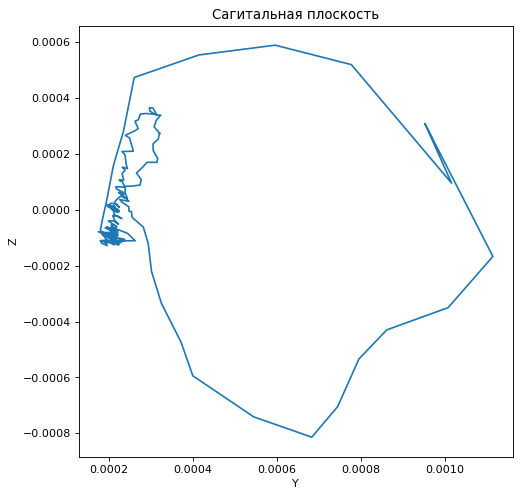

In [286]:
plt.figure(figsize=(7, 7), dpi=80)
plt.plot(df_term.y,df_term.z)
plt.title('Сагитальная плоскость')
plt.xlabel('Y')
plt.ylabel('Z')
plt.plot()

[]

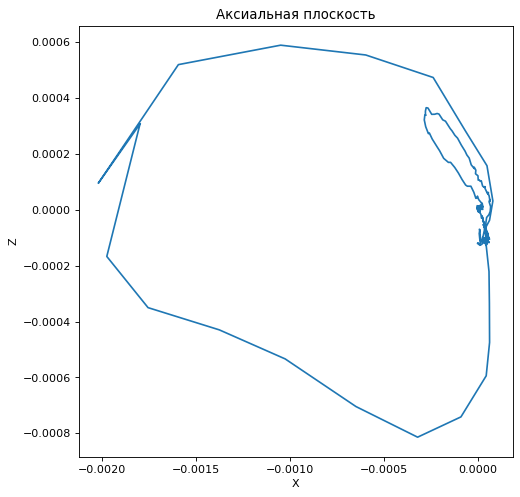

In [287]:
plt.figure(figsize=(7, 7), dpi=80)
plt.plot(df_term.x, df_term.z)
plt.title('Аксиальная плоскость')
plt.xlabel('X')
plt.ylabel('Z')
plt.plot()

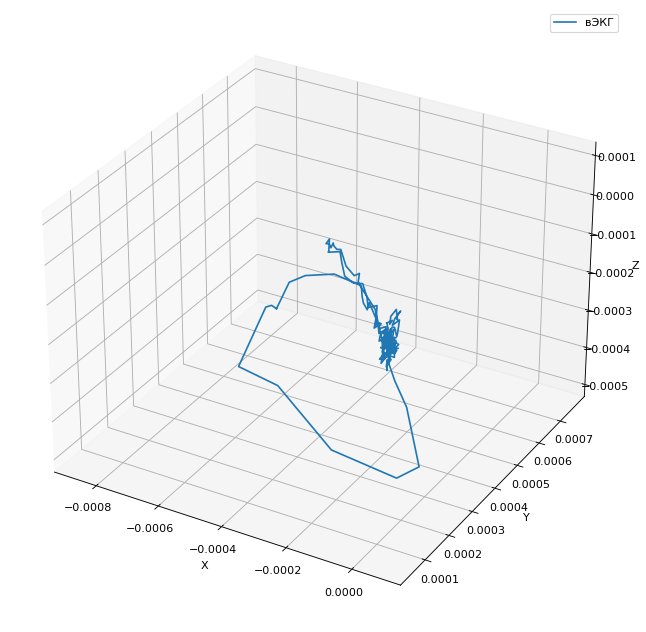

In [95]:
ax = plt.figure(figsize=(10, 10), dpi=80).add_subplot(projection='3d')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.plot(df_term.x,df_term.y,df_term.z, label='вЭКГ')
ax.legend()

plt.show()

### Определение угла QRST

Угол QRST - это угол между вектором, представляющим среднюю электродвижущую силу QRS, и вектором, представляющим среднюю электродвижущую силу волны ST-T
(Источник: https://meduniver.com/Medical/cardiologia/1458.html MedUniver)

Поэтому нужно найти середины временных интервалов QRS и ST-T, и для 2 полученных значений времени  определить координаты векторов ЭДС.
Для этого нужно определить на графике ЭКГ(I отведение) координату X для 3 точек, которые пользователь находит по интерактивному графику:

1. R-зубца (предполагается, что это середина интервала QRS)
2. Начала интервала ST
3. Конца интервала T

Полученные координаты следует внести отдельно (например, ввод с клавиатуры)

In [24]:
# *** График ЭКГ в интерактивном режиме *** #

#!pip install cufflinks plotly

# Стандартное импортирование plotly
from plotly.offline import iplot

# Использование cufflinks в офлайн-режиме
import cufflinks
cufflinks.go_offline()

# Настройка глобальной темы cufflinks
cufflinks.set_config_file(world_readable=True, theme='pearl', offline=True)

In [343]:
df_new.iloc[start:end,1].iplot(xTitle='Seconds', yTitle='U, mV', title=channels[0])

In [341]:
#введение полученных координат

t_R=2.044 #время R-зубца
t_ST_start=2.080 #время начала интервала ST
t_T_end=2.356 #время окончания Т-зубца

t1=t_R #время для усреднённого вектора интервала QRS 
t2=(t_T_end+t_ST_start)/2

t_d=Ts

if (t2*1000) % (time1[1]*1000) != 0.0:
   t2=(t_T_end+t_ST_start)/2 + 0.001
t2

2.218

Нахождение координат усреднённых векторов для интервала QRS и ST-T 

In [335]:
df_angle = df_term[(df_term.index == t1) | (df_term.index == t2)]
df_angle

,ECG I-Ref,ECG II-Ref,ECG III-Ref,ECG AVR-Ref,ECG AVL-Ref,ECG AVF-Ref,ECG V1-Ref,ECG V2-Ref,ECG V3-Ref,ECG V4-Ref,ECG V5-Ref,ECG V6-Ref,x,y,z
time,,,,,,,,,,,,,,,
2.044,0.00087,0.001080,0.000210,-0.00097,0.000320,0.000650,-0.00073,-0.00057,0.00027,0.00070,0.00091,0.00084,-0.000868,0.000763,-0.000503
2.218,0.00009,0.000195,0.000105,-0.00014,-0.000015,0.000155,-0.00002,0.00015,0.00003,0.00007,0.00012,0.00004,-0.000061,0.000151,0.000021


In [342]:
x1=df_angle['x'].iloc[0]
y1=df_angle['y'].iloc[0]

x2=df_angle['x'].iloc[1]
y2=df_angle['y'].iloc[1]

#print(x1,y1,x2,y2)

Нахождение косинуса угла между векторами

In [337]:
cos_alpha=(x1*x2+y1*y2)/(((x1**2+y1**2)**0.5)*((x2**2+y2**2)**0.5))
cos_alpha

0.8932098994082263

Определение угла

In [339]:
from math import acos, pi

angle=acos(cos_alpha)*180/pi
angle

26.72058521926947

Пример реализации пикового детектирования при фильтрации ФВЧ всех входных сигналов ЭЭГ

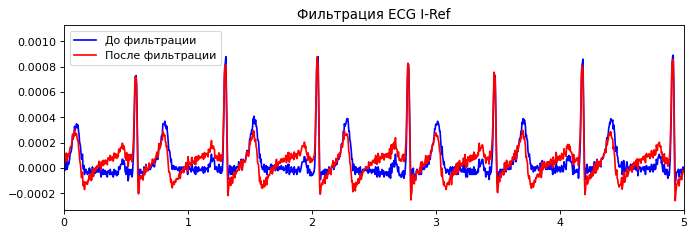

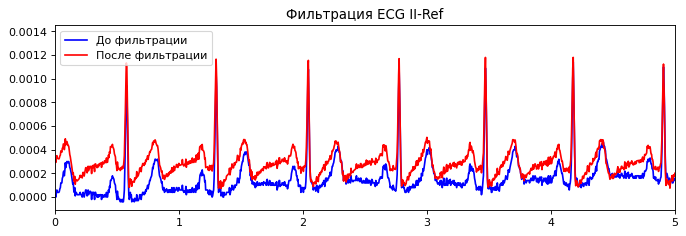

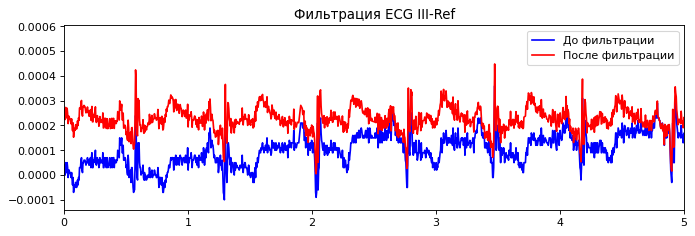

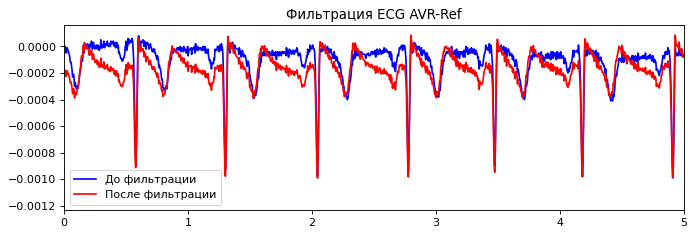

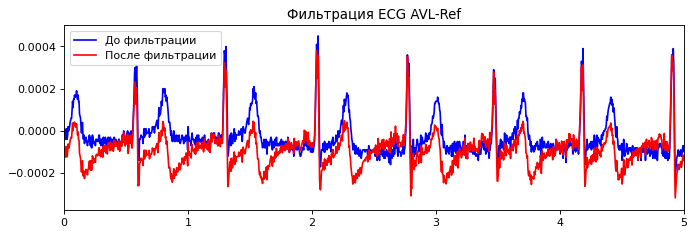

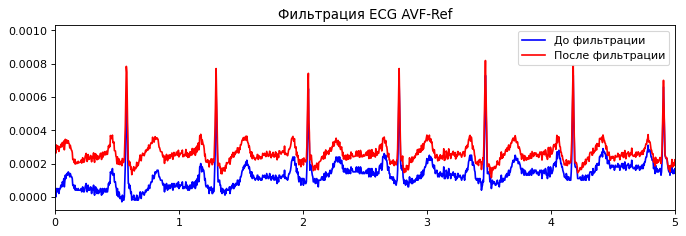

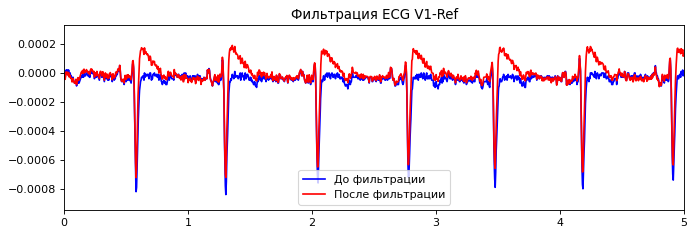

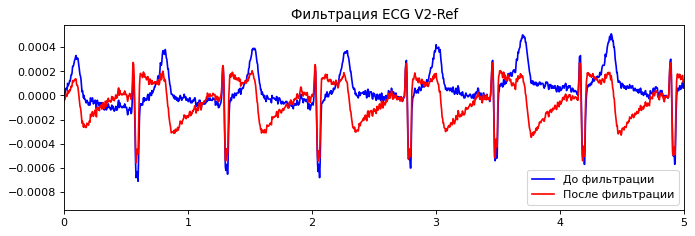

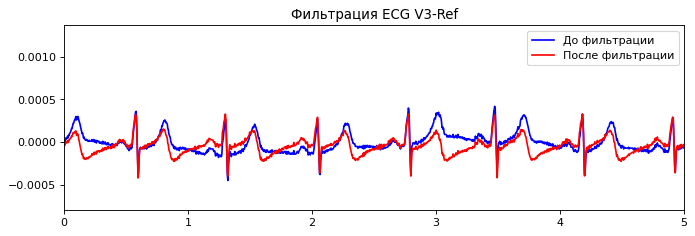

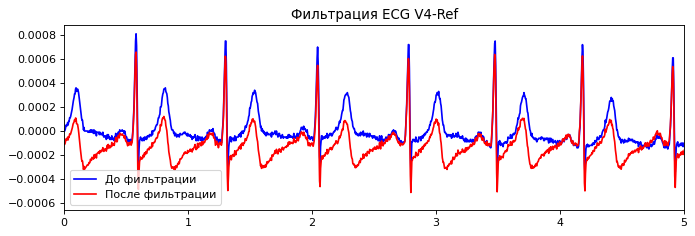

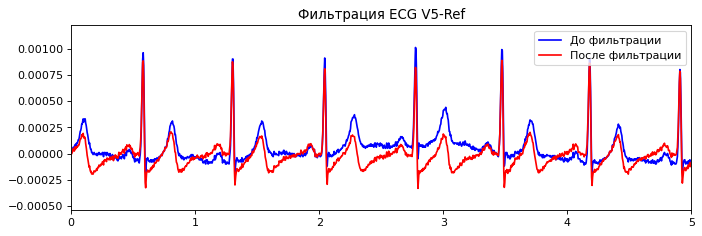

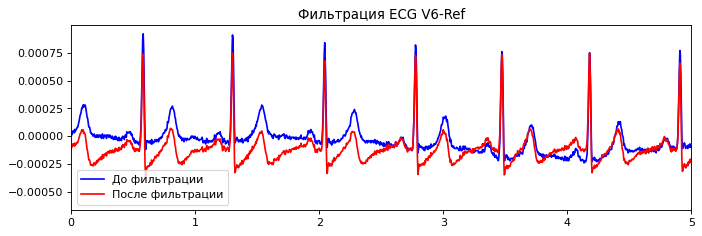

In [127]:
        f_sreza = float(input('Введите частоту среза ФВЧ фильтра 3 порядка в Гц:'))
        df_new_2 = pd.DataFrame()
        for graph in channels:
            sig = np.array(df_new[graph])
            sos = signal.butter(3, f_sreza, 'hp', fs=fd, output='sos')
            avg = np.mean(sig)
            filtered = signal.sosfilt(sos, sig)
            filtered += avg
            figure(figsize=(10, 3), dpi=80)
    
            plt.plot(time1, sig, color='blue')
            plt.plot(time1, filtered, color='red')
            plt.title('Фильтрация '+ str(graph))
            plt.legend(["До фильтрации", "После фильтрации"])
            plt.xlim([0, 5])
            plt.show()
                    
            df_new_2[graph] = pd.Series(filtered)

        df_ = df_new_2
        t = []
        for i in range(df_new.shape[0]):
            t.append(i*Ts/2)
        sig = np.array(df_['ECG I-Ref'])
        dataset_check = []
        middles = []
        for i in range(0, len(sig)-window, 6):
            piece = sig[i:i+window] / np.max(np.abs(sig[i:i+window]))
            piece = piece - np.mean(piece)
            middle = (i + i + window) / 2
            middles.append(middle)
            dataset_check.append(piece)
        df_check = pd.DataFrame(dataset_check)
        test_preds = model.predict(df_check, prediction_type="Class")
        peaks = np.where(test_preds > 0)[0]

        # Сделаем временный сигнал, который всегда имеет min значение = 0
        temp_sig = sig
        if min(sig) < 0:
            temp_sig = sig + abs(min(sig))
        if min(sig) > 0:
            temp_sig = sig - abs(min(sig))

        h = max(temp_sig)/1.5  # Выберем только те пики, которые >
        true_peaks = []

        for i in peaks:
            m = int(middles[i])
            if temp_sig[m]>h:
                true_peaks.append(i)

Добавил возможность на вход функции подавать сразу значения с каого по какой период необходимо построить результат. Для этого надо в качестве параметра n_term передать значение списка [номер первого периода, до какого периода включительно]

---

## Итоговая функция vECG:
Входные параметры: <br>
>file <br>

Необходимо передать путь к файлу (формат .edf)<br>
>n_term <br>

Можно передать номер периода ЭКГ сигнала (тип int)<br>
Или передать пременную типа list, в которой первый элемент - с какого периода начать (лучше >1), а второй элемент - номер периода до которого вести запись (включительно) <br>
ex: [2,4] - выдаст результат вЭКГ для диапазона со 2 по 4 пориод включительно

>filt <br>

Данный параметр указывает, нужно ли проводить цифровую фильтрацию с помошью фильтра Баттерворта 3 порядка (ФВЧ). Данная фильтрация позволит убрать низкочастотные артефакты дыхания и улучшит качество работы пикового детектирования, которое реализуется с помощью предобученной модели градиентного бустинга. (Данный параметр filt по умолчанию равен False)

>f_sreza <br>

Данный параметр задает величину частоты среза ФВЧ фильтра. Так что его стоит использовать лишь при работе с n_term=True
(Данный параметр f_sreza по умолчанию равен 0.5)

### Как запускать код на python 3:

```rb
# Загрузка функции и требуемых библиотек
from func import *
!pip install -r requirements.txt

# Запуск функции:
vECG(file="Data VECG\PatientA__Exam_1_0.edf", n_term=3, filt=True, f_sreza=0.5)
```



Запустим данный код локально без загрузки библиотек из файла requirements.txt

Extracting EDF parameters from d:\Python_notebooks\repository_Koldim2001\vector_ECG\Data VECG\PatientA__Exam_1_0.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Запрошен 3 период
Результаты вычисления:


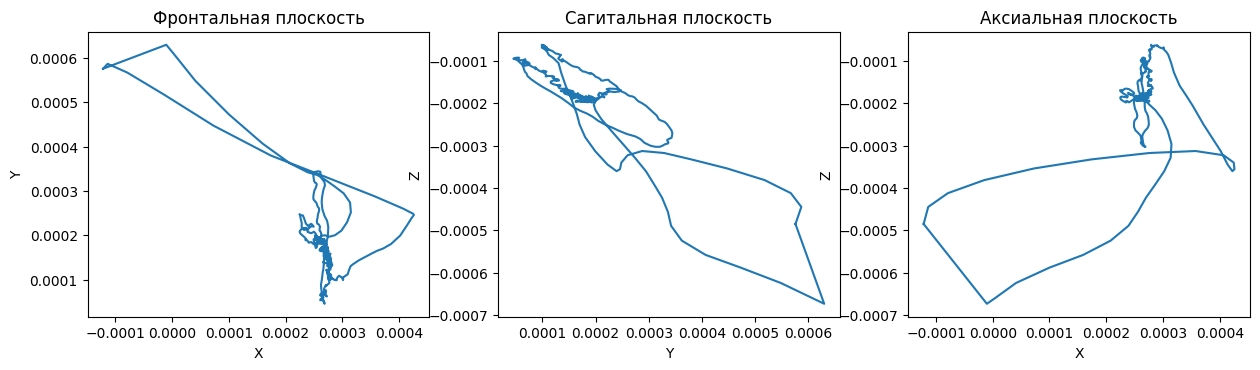

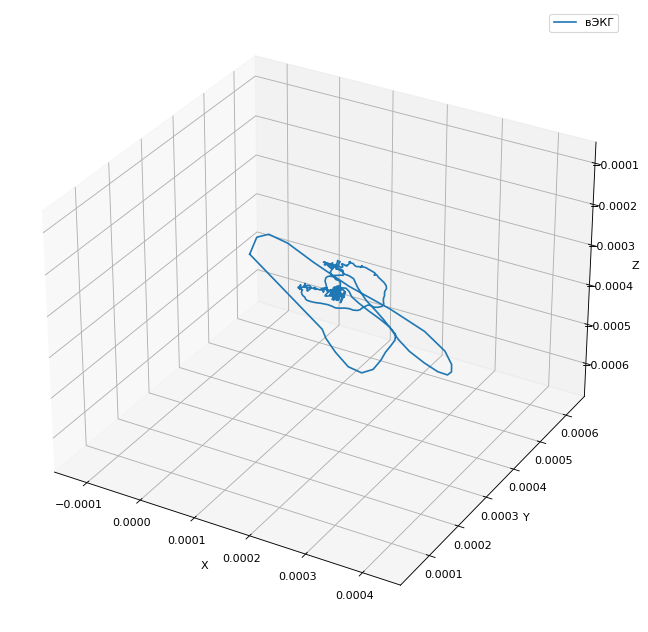

In [19]:
from func import *

vECG(file="Data VECG\PatientA__Exam_1_0.edf", n_term=3, filt=True, f_sreza=0.5)

## Итоговая функция c демонстрацией промежуточных этапов:

Может понадобиться для откладки

Extracting EDF parameters from d:\Python_notebooks\repository_Koldim2001\vector_ECG\Data VECG\PatientA__Exam_1_0.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


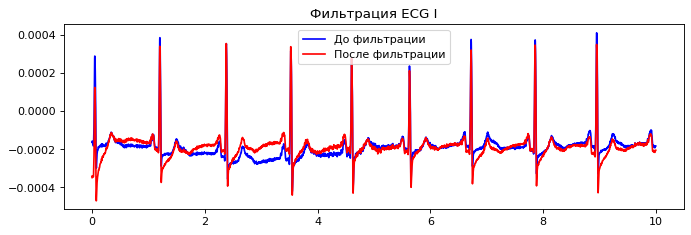

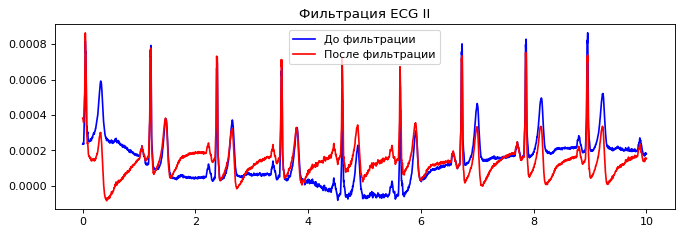

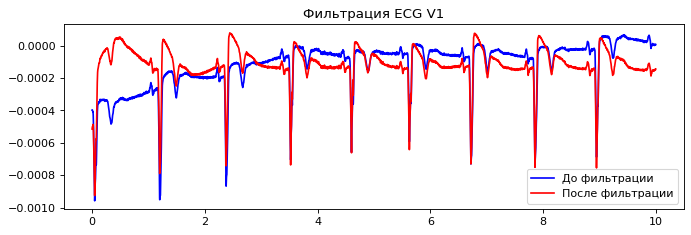

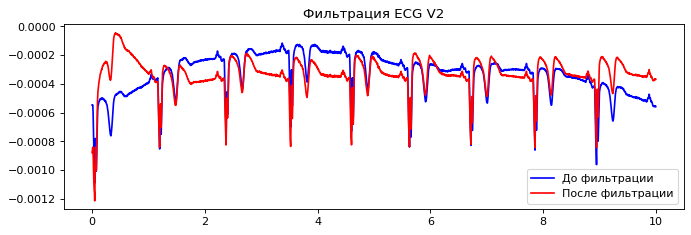

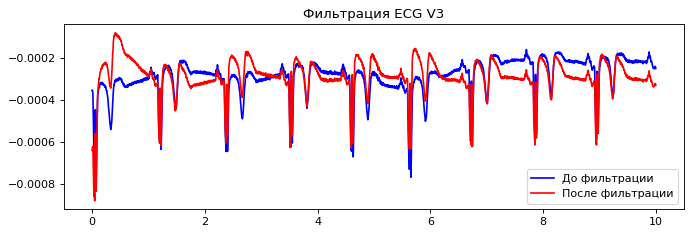

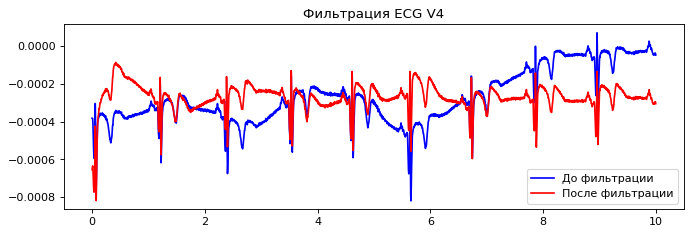

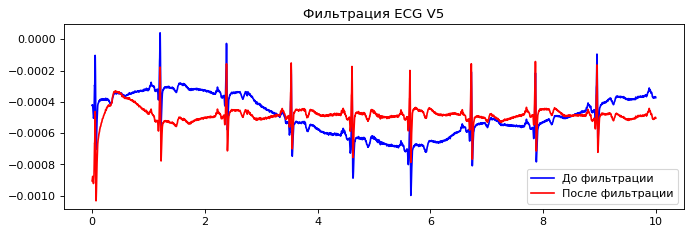

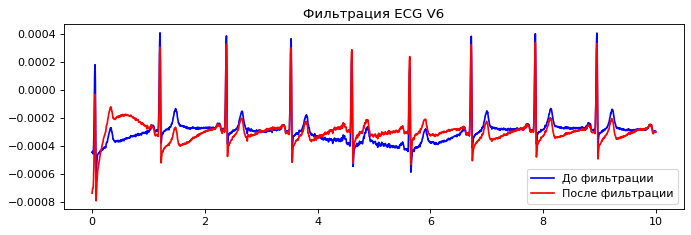

Вот, как ML модель распознала QRS пики после фильтрации сигнала:


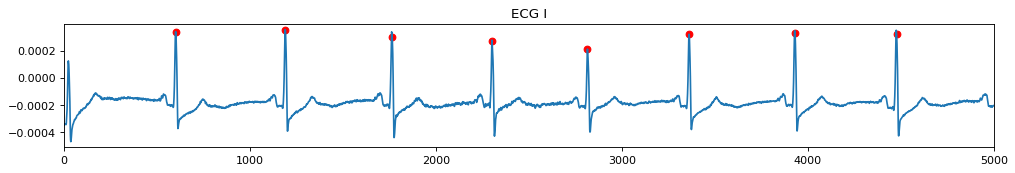

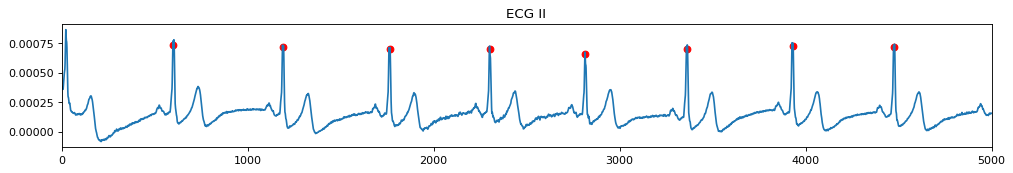

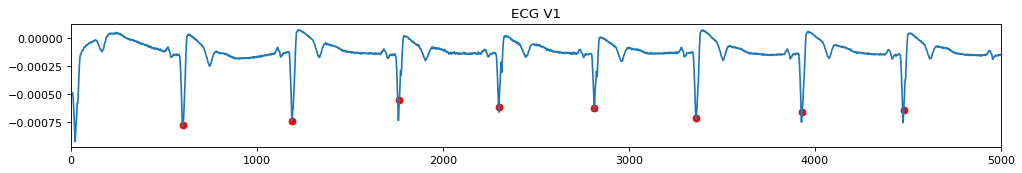

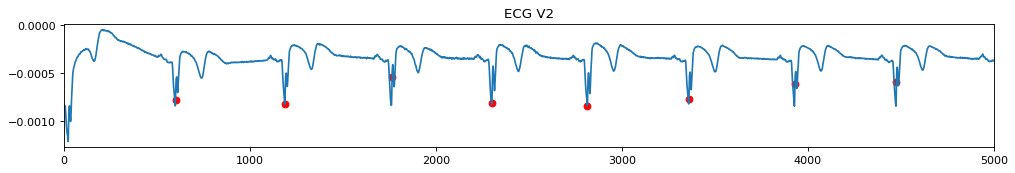

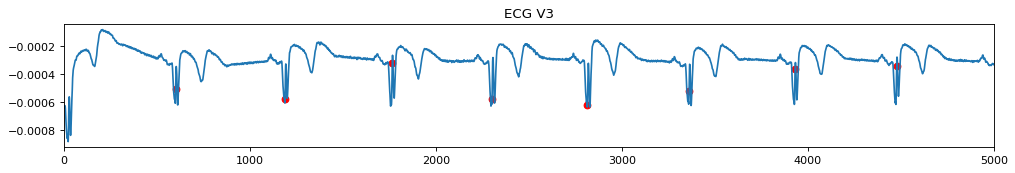

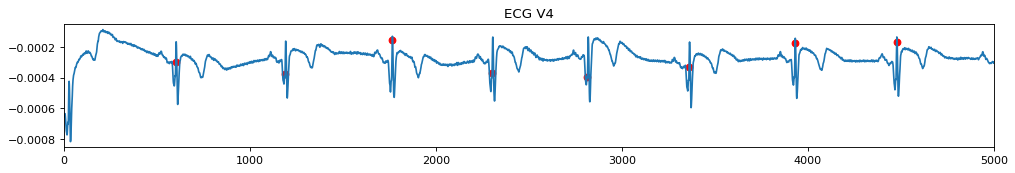

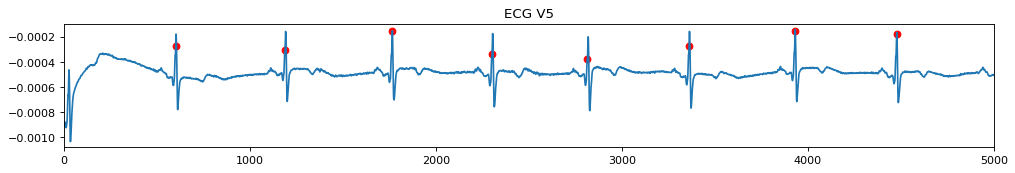

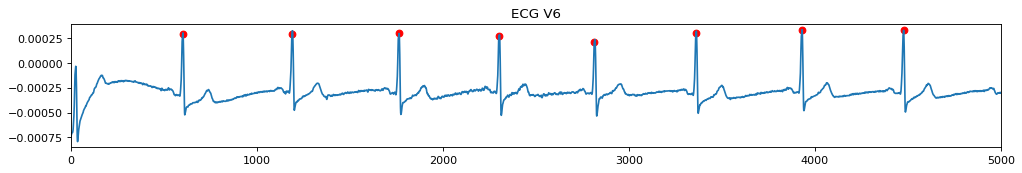

Запрошен диапазон с 3 по 4 период включительно
Результаты вычисления:


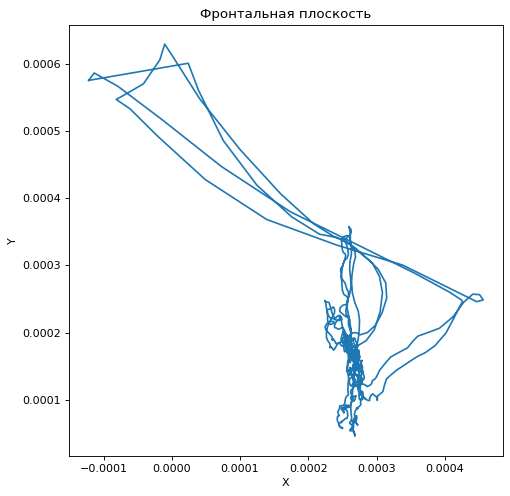

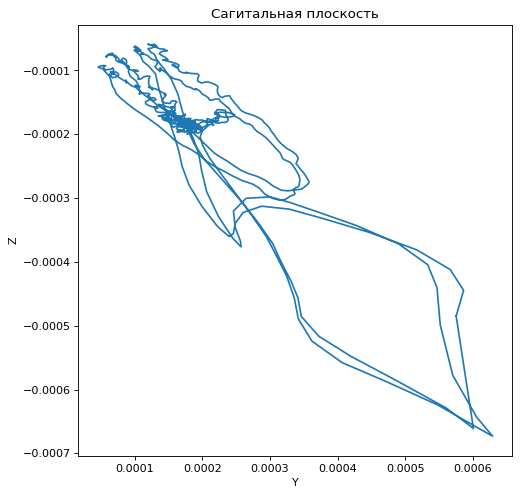

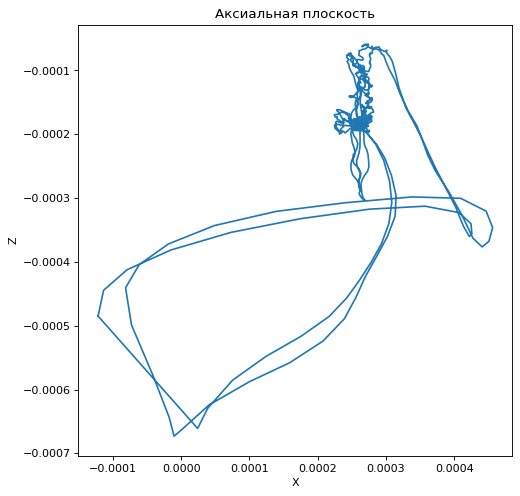

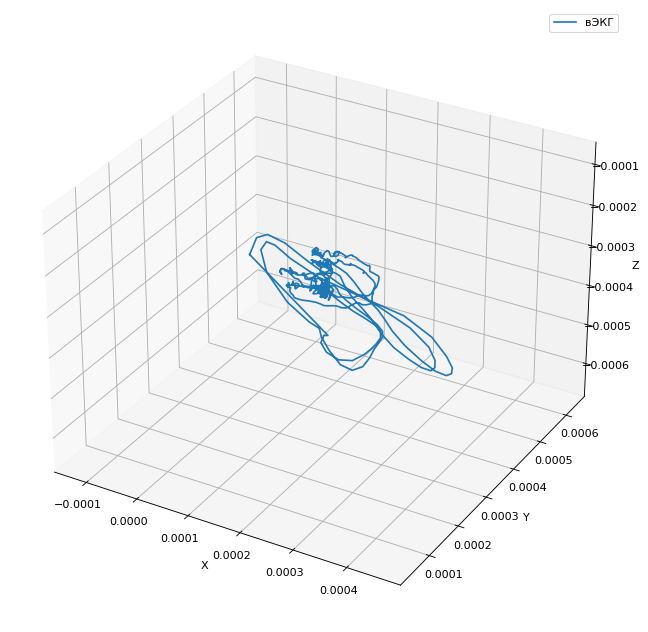

In [42]:
function(file="Data VECG\PatientA__Exam_1_0.edf", n_term=[3,4], filt=True, f_sreza=0.5)